In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# import warnings
# warnings.filterwarnings('ignore')

In [2]:
path = "../data/all_salary_stats.csv"
df= pd.read_csv(path)
df.drop(columns=['Position(s)','Unnamed: 0','Unnamed: 0.1',
                 'First Name', 'Last Name', 'name', '_merge',
                 'Guaranteed Compensation'],inplace=True)
df.shape

(705, 103)

In [96]:
df[df['player_name']=='Walker Zimmerman']

,fb_id,player_name,Squad_from_op,Opposing_Poss,Opposing_Touches,Player,Nation,Position,Total_tackles,Tackles_Won,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Club,Base Salary
376,220fa883,Walker Zimmerman,Nashville,53.5,21537,Walker Zimmerman\220fa883,us USA,DF,27,15,...,0,0,0,2.2,2.2,0.08,0.8,0.8,Nashville SC,"$925,000.00"


In [37]:
## start with df corr of key features !!! 

# Feature engineering 


### 1-convert player season data to per 90 stats to adjust for different amounts of games played per player.

### 2- create possesion adjusted stats for defensive KPIs to better show defenders metrics 

## objective -1 Adjust season stats to per ninety stats for accurate stat comparison.

In [3]:
def per_90(cols,df):
    # create list of games played values and map anything less than 1 to one 
    nines=[i if i >1 else 1 for i in df['Nineties'] ]
    # use new list to do calc so not dividing by value less than 1 
    for col in cols:
        df[col] = df[col]/nines
    return df


In [4]:
## create list of columns to be adjusted to per 90 stats
cols =  [
         # this needs to be done on by teams 90's 
    # def stats
    'Total_tackles', 'Tackles_Won', 'Tackles_Def_3rd',
       'Tackles_Mid_3rd', 'Tackles_Att_3rd', 'Num_Dribblers_tackled',
       'Num_Dribbled_past', 'total_pressing', 'Won_ball_5_sec',
    
       # 'Tackle_pct_won',- pct not scaled 
    'pres_Def_3rd', 'pres_Mid_3rd', 'pres_Att_3rd',
       'Blocks', 'Blocked_shots', 'Blocked_SOT', 'Blocked_pass',
       'Interceptions', 'Tackles_and_Ints', 'Clearences',
    # passing stats
'xA','Key_pass','Comp_prog','Total_Cmp','Total_Att','Total_Tot_Dist','Total_Prg_Dist','Short_Cmp','Short_Att','Medium_Cmp','Medium_Att','Long_Cmp','Long_Att',
'touches','touches_def_box','touches_def_3rd','touches_mid_3rd','touches_att_3rd','touches_att_box','touch_live',
    # attacking stats
    'dribble_Succ','dribble_Att','num_dribble_past','dribble_megs','carries','carries_dist','carries_prog_dist','carries_prog','carries_att_3rd','carries_att_box','miss_control','dispossed','recep_targ',
'recep_succ','Yellow_cards','Red_cards','Second_yellow','Fouls','Fouls_drawn','Offsides','Crosses','def_interceptions',
    # mish stats 
    'from_mish_tackles_won','PK_won','PK_conceded','OG',
'Recoveries','Aerial_Duels_lost','Gls','Sh','SoT','Sh/90','SoT/90','G/Sh','G/SoT','Dist','FK','PK','PKatt', 'xG','npxG','npxG/Sh','G-xG','np:G-xG'


]

In [5]:

df =  per_90(cols,df)
df[['player_name','Opposing_Touches','Total_tackles','Key_pass','from_mish_tackles_won','Total_Cmp','Total_Att']].head(3)

,player_name,Opposing_Touches,Total_tackles,Key_pass,from_mish_tackles_won,Total_Cmp,Total_Att
0,Carles Gil,20024,0.393701,5.275591,0.157480,48.818898,65.708661
1,Julian Gressel,20526,1.538462,3.210702,0.635452,37.324415,57.926421
2,Emanuel Reynoso,20887,2.226415,3.433962,1.622642,42.113208,61.056604


In [7]:
# maybe one graph after all features are built 


# graph = df.loc[(df['Position']!='GK')&(df['Aerial_win_pct']<100)&
#                (df['Aerial_win_pct']>0)&(df['Nineties']>5)]


# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(18.5, 10.5)
# g = sns.scatterplot(data=graph, x ='xG', y='xA',hue='Position', ax=ax).set(title='MLS 2021 xA. Vs xG per 90')


In [8]:
df.loc[df['xG']>1][['xG','xA','player_name', 'Squad_from_op','Nineties','Gls']]

,xG,xA,player_name,Squad_from_op,Nineties,Gls
470,1.272727,0.090909,Abu Danladi,Nashville,1.1,0.909091


In [12]:
df.loc[df['xA']>.7][['xG','Gls','Key_pass','xA','player_name', 'Squad_from_op','Nineties']]

,xG,Gls,Key_pass,xA,player_name,Squad_from_op,Nineties
471,0.352941,0.588235,1.764706,0.764706,Léo Chú,Seattle,1.7


## Insight 
- feature engineering gives players who have not played to many games some edge and can be filtered out for models if needed. 
- The expected trends of forwards haivng the most xG by the green points to the right side of the graph.
- Midfielders having the most xA or a mix of both can be seen  and the blue ones towards the top half of the graph around 5 to 10 xG. 
- There is only two defenders with xA above 6 and no defenders above 4 xG, the majority are clusterd in the bottom left of the graph. 

In [53]:
## check players who played less than 1 game no not have increased features

df.loc[(df['player_name']=='Jason Pendant') | (df['player_name']=='Jordan Harvey') ][['player_name', 'Squad_from_op',
       'Long_Att','Long_Cmp','Long_Cmp_pct', 'Nation', 'Position', 'Nineties',
       'xA', 'Key_pass']]

,player_name,Squad_from_op,Long_Att,Long_Cmp,Long_Cmp_pct,Nation,Position,Nineties,xA,Key_pass
605,Jason Pendant,NY Red Bulls,4.0,3.0,75.0,fr FRA,DF,0.1,0.0,0.0
609,Jordan Harvey,Los Angeles FC,5.0,5.0,100.0,us USA,DF,0.1,0.0,0.0


check to confirm the new df has per 90 stats instead of season totals 

## Objective - 2  Create possesion adjusted metrics , " pAdj "

using stat per 1000 opponent touches as scale to create pAdj stat 
ex: tackles per 1000 opponent touches instead of just tackles per 90 

In [13]:
df['Opposing_Touches'].value_counts().head()

17449    30
21171    30
20480    28
20501    28
21209    28
Name: Opposing_Touches, dtype: int64

In [14]:
# each team played 34 games so to get opposing touches per 90 divide by 34

df['Opposing_Touches'] = df['Opposing_Touches']/34
df['Opposing_Touches'].describe()

count    705.000000
mean     595.045807
std       30.746442
min      513.205882
25%      577.647059
50%      593.529412
75%      620.470588
max      659.294118
Name: Opposing_Touches, dtype: float64

In [15]:
   # defensive stats to be adjusted by possesion 
    
def_cols=[
    
        'Total_tackles', 'Tackles_Won', 'Tackles_Def_3rd',
       'Tackles_Mid_3rd', 'Tackles_Att_3rd', 'Num_Dribblers_tackled',
       'Num_Dribbled_past', 'total_pressing', 'Won_ball_5_sec',
       #'Tackle_pct_won', - pct not adjusted
    'pres_Def_3rd', 'pres_Mid_3rd', 'pres_Att_3rd',
       'Blocks', 'Blocked_shots', 'Blocked_SOT', 'Blocked_pass',
       'Interceptions', 'Tackles_and_Ints', 'Clearences',
    
      # defensive stats to be adjusted by possesion 
    'Yellow_cards','Red_cards','Second_yellow','Fouls','def_interceptions',
    'from_mish_tackles_won','PK_conceded','OG','Recoveries','Aerial_Duels_lost']

In [16]:
df['def_interceptions'].describe()

count    705.000000
mean       1.325073
std        0.962239
min        0.000000
25%        0.510949
50%        1.323529
75%        1.959459
max        5.000000
Name: def_interceptions, dtype: float64

In [17]:
def pAdj(df,cols):
  """ create possesion adjusted defensive stats and remove orignial"""
  for col in cols:
    label = 'pAdj_'+col
  
    df[label] = (df[col]/df['Opposing_Touches']) * 1000
    df.drop(columns=[col],inplace=True)
  
  return df

In [18]:
df=pAdj(df,def_cols)
df[[ 'player_name','pAdj_def_interceptions','pAdj_from_mish_tackles_won', 'pAdj_Total_tackles', 'pAdj_Tackles_Won','pAdj_Recoveries','pAdj_Aerial_Duels_lost']].head()




,player_name,pAdj_def_interceptions,pAdj_from_mish_tackles_won,pAdj_Total_tackles,pAdj_Tackles_Won,pAdj_Recoveries,pAdj_Aerial_Duels_lost
0,Carles Gil,1.537525,0.267396,0.668489,0.267396,10.963222,0.267396
1,Julian Gressel,3.767145,1.052585,2.548363,1.052585,13.905196,1.661976
2,Emanuel Reynoso,1.658520,2.641347,3.624174,2.641347,12.162481,1.105680
3,Albert Rusnák,1.304421,0.834829,1.252244,0.834829,10.591897,0.208707
4,Maximiliano Moralez,1.526455,1.725558,3.185646,1.725558,11.083393,0.663676


In [19]:
df['pAdj_def_interceptions'].describe()

count    705.000000
mean       2.231026
std        1.625044
min        0.000000
25%        0.847926
50%        2.225200
75%        3.271473
max        8.502551
Name: pAdj_def_interceptions, dtype: float64

In [20]:
df.loc[df['pAdj_def_interceptions']>8][['player_name','pAdj_def_interceptions','Key_pass', 'Squad_from_op','Nineties','Gls']]

,player_name,pAdj_def_interceptions,Key_pass,Squad_from_op,Nineties,Gls
455,Nathan Cardoso,8.359709,0.15625,San Jose,19.2,0.104167
613,Alejandro Fuenmayor,8.015465,0.00000,Houston Dynamo,3.0,0.000000
691,Youba Diarra,8.502551,0.00000,NY Red Bulls,1.4,0.000000


3. IDENTIFYING AND CREATING FEATURES
Variables and features are almost synonymous. The primary difference tends to be the context in which they are used; in machine learning, it is common practice to identify predictive features in your data whereas in parametric statistics, features are often referred to as variables and variables can include the response variable which you predict with your model.

The goal of identifying features is to use your exploratory work to isolate features that will be most helpful in constructing a predictive model. In addition to recognizing those features, it often behooves one to create additional features for inclusion in your predictive modeling work.
Once you have identified the critical features for your model development, you may realize you need to create additional features to augment your original data. You can do this through the development of combining features or revaluing them to emphasize specific relationships. Additional features can also be created through Principal Components Analysis or Clustering.

Building a Principle Components Analysis (PCA) is a useful way to apply a dimension reduction application to identify which features contain the most amount of variation within your development dataset. The predictive model can be constructed on the principal components themselves as features, resulting in feature reduction. Feature reduction is helpful when your data set has too many features to choose from, and you need a more automated way to reduce the number of input features for modeling. There are different flavors of dimension reduction methods based on multi-dimensional scaling, such as Principal Coordinate Analysis. Lasso regression is another tool for a semi-automated feature selection approach. Review these methods to determine the best strategy for your project.


Clustering (e.g. K-means clustering) is an excellent exploratory analysis method for creating additional features which in this case would be the clusters themselves. The clusters can be used in conjunction with additional features if you find them to be valid after review.

In [21]:
## create tackle int blocks from pAdj stats  

df['pAdj_Tackle_int_blocks'] = df['pAdj_Tackles_Won']+df['pAdj_def_interceptions']+df['pAdj_Blocks']


In [22]:
df['pAdj_Tackle_int_blocks'].describe()

count    705.000000
mean       5.995421
std        3.481899
min        0.000000
25%        3.369673
50%        6.441997
75%        8.339447
max       21.104904
Name: pAdj_Tackle_int_blocks, dtype: float64

In [23]:
df.loc[df['pAdj_Tackle_int_blocks']>15][['player_name','pAdj_Tackle_int_blocks','pAdj_def_interceptions','pAdj_Total_tackles','pAdj_Blocks', 'Squad_from_op','Nineties']]
                                        
                                        

,player_name,pAdj_Tackle_int_blocks,pAdj_def_interceptions,pAdj_Total_tackles,pAdj_Blocks,Squad_from_op,Nineties
455,Nathan Cardoso,18.429358,8.359709,8.359709,3.894864,San Jose,19.2
513,Franco Ibarra,16.349783,4.479392,8.062906,7.167028,Atlanta Utd,8.7
535,Chris Gloster,21.104904,7.034968,12.311194,3.517484,NYCFC,0.8


# Create true tackle win pct feature to beter measure player tackle percentage 
 - Usual tackl win % is measured by - tackl won/ (tackle won +tackle lost)
 
 - Tifo calculates True tackle win % to better represent players defensive actions. their equation is (total tackles / total tackles +challanges lost + fouls when attempting a tackle)
 
 - With the fb_ref features my true tackle win % will be calculated by (total tackles + number dribbler tackled / total tackles + number dribbled past +fouls)

In [24]:
df['Tackle_pct_won'].describe()

count    705.000000
mean      28.241594
std       10.658468
min        0.000000
25%       24.500000
50%       28.241594
75%       32.600000
max      100.000000
Name: Tackle_pct_won, dtype: float64

In [25]:
df['lost_tackles']= df['pAdj_Total_tackles']-df['pAdj_Tackles_Won']
df['lost_tackles'].describe()

count    705.000000
mean       1.071205
std        0.865499
min        0.000000
25%        0.471064
50%        0.980611
75%        1.541527
max        7.007304
Name: lost_tackles, dtype: float64

In [26]:
df[df['pAdj_Total_tackles']>10][['player_name','pAdj_Total_tackles','pAdj_Tackle_int_blocks','pAdj_def_interceptions','pAdj_Total_tackles','pAdj_Blocks', 'Squad_from_op','Nineties']]
                                        
                                        

,player_name,pAdj_Total_tackles,pAdj_Tackle_int_blocks,pAdj_def_interceptions,pAdj_Total_tackles,pAdj_Blocks,Squad_from_op,Nineties
535,Chris Gloster,12.311194,21.104904,7.034968,12.311194,3.517484,NYCFC,0.8


In [34]:

# calculation for true tackle
df['True_tackle_pct'] = (df['pAdj_Total_tackles']/(df['pAdj_Total_tackles']+df['lost_tackles']+
                                                   df['pAdj_Num_Dribbled_past']+df['pAdj_Fouls']) *100)

# deal with edge cases that dont give percent keep original tackle pct
df.loc[df['True_tackle_pct'].isnull(),'True_tackle_pct'] = df['Tackle_pct_won']
df.loc[df['True_tackle_pct']==0,'True_tackle_pct'] = df['Tackle_pct_won']
# check if all edge cases delt with
print(df['True_tackle_pct'].isnull().sum())
print(len(df.loc[df['True_tackle_pct']== 0]))
#check distribution of new feature
df['True_tackle_pct'].describe()   

0
28


count    705.000000
mean      35.006430
std       12.970339
min        0.000000
25%       29.577465
50%       36.263736
75%       41.176471
max      100.000000
Name: True_tackle_pct, dtype: float64

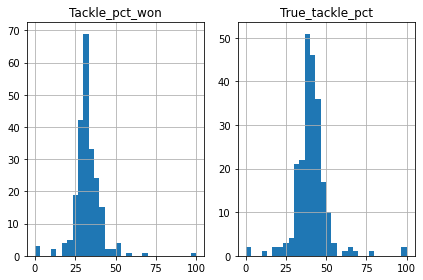

In [35]:
df.loc[df['Position']=='DF'][['Tackle_pct_won','True_tackle_pct']].hist(bins=30)
plt.tight_layout()
plt.show()

## True tackle pct for defenders has moved the median and the mode towards the right while also creating a wider curve than the original tackle pct. 

In [36]:
df[df['Tackle_pct_won']> 50.0][['player_name','Nineties','Squad_from_op','True_tackle_pct','Tackle_pct_won','pAdj_Total_tackles','pAdj_Num_Dribblers_tackled','pAdj_Num_Dribbled_past','pAdj_Fouls','pAdj_Tackle_int_blocks','pAdj_def_interceptions','pAdj_Total_tackles','pAdj_Blocks', 'Squad_from_op']]
                                        

,player_name,Nineties,Squad_from_op,True_tackle_pct,Tackle_pct_won,pAdj_Total_tackles,pAdj_Num_Dribblers_tackled,pAdj_Num_Dribbled_past,pAdj_Fouls,pAdj_Tackle_int_blocks,pAdj_def_interceptions,pAdj_Total_tackles,pAdj_Blocks,Squad_from_op
498,Handwalla Bwana,1.1,Nashville,60.000000,51.9,4.305487,1.435162,1.435162,1.435162,8.610974,2.870325,4.305487,1.435162,Nashville
578,Liam Fraser,0.4,Toronto FC,50.000000,62.5,1.605970,0.000000,1.605970,0.000000,1.605970,0.000000,1.605970,0.000000,Toronto FC
602,Robert Castellanos,1.0,Nashville,66.700000,66.7,0.000000,0.000000,1.578679,0.000000,7.893393,4.736036,0.000000,3.157357,Nashville
609,Jordan Harvey,0.1,Los Angeles FC,100.000000,100.0,1.660156,0.000000,0.000000,0.000000,1.660156,0.000000,1.660156,0.000000,Los Angeles FC
612,Julian Dunn-Johnson,1.0,Toronto FC,66.666667,57.1,3.211941,0.000000,0.000000,1.605970,8.029852,1.605970,3.211941,3.211941,Toronto FC
645,Evan Bush,4.0,Columbus Crew,100.000000,100.0,0.000000,0.000000,0.439504,0.000000,0.000000,0.000000,0.000000,0.000000,Columbus Crew
663,Zac MacMath,6.5,Real Salt Lake,100.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.271320,0.000000,0.000000,0.271320,Real Salt Lake
675,Gabriel Slonina,11.0,Chicago Fire,66.700000,66.7,0.000000,0.000000,0.000000,0.153349,0.153349,0.000000,0.000000,0.153349,Chicago Fire
677,Mason Stajduhar,5.0,Orlando City,100.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Orlando City


# Objectives

- create descriptive features for defenders that will be used in clustering models

In [41]:
# consolidate short and medium passing percentage
df['avg_short+long_pass_pct'] = (df['Short_Cmp_pct']+df['Medium_Cmp_pct'])/2

## get ratio of long balls for players to have a feel about who passes at distance the most 
df['ratio_long_balls']=df['Long_Att']/df['Total_Att']

## who effecivly moves the ball up the field on the dribble or through the air 
df['prog_carry+lng_comp+crosses'] = df['carries_prog']+df['Long_Cmp']+df['Crosses']

# put all of the attack minded touch features into one 
df['attacking_touches']= df['touches_att_3rd']+df['touches_att_box']+ df['num_dribble_past'] +df['carries_att_3rd']+df['carries_att_box']


df.loc[(df['Position']=='DF')][['avg_short+long_pass_pct','ratio_long_balls','prog_carry+lng_comp+crosses','attacking_touches']].describe()

,avg_short+long_pass_pct,ratio_long_balls,prog_carry+lng_comp+crosses,attacking_touches
count,227.000000,227.000000,227.000000,227.000000
mean,88.849559,0.200758,10.324587,12.870451
std,4.687214,0.069469,3.302164,9.953301
min,66.300000,0.048649,1.000000,0.000000
25%,85.975000,0.145345,8.133214,3.910742
50%,89.200000,0.196958,10.598291,9.190283
75%,92.500000,0.250833,12.593765,21.456015
max,100.000000,0.438547,22.636364,38.461538


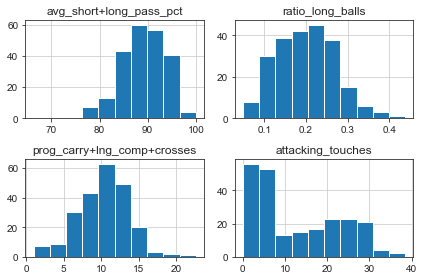

In [42]:
df.loc[(df['Position']=='DF')][['avg_short+long_pass_pct','ratio_long_balls','prog_carry+lng_comp+crosses','attacking_touches']].hist()
plt.tight_layout()
plt.show()

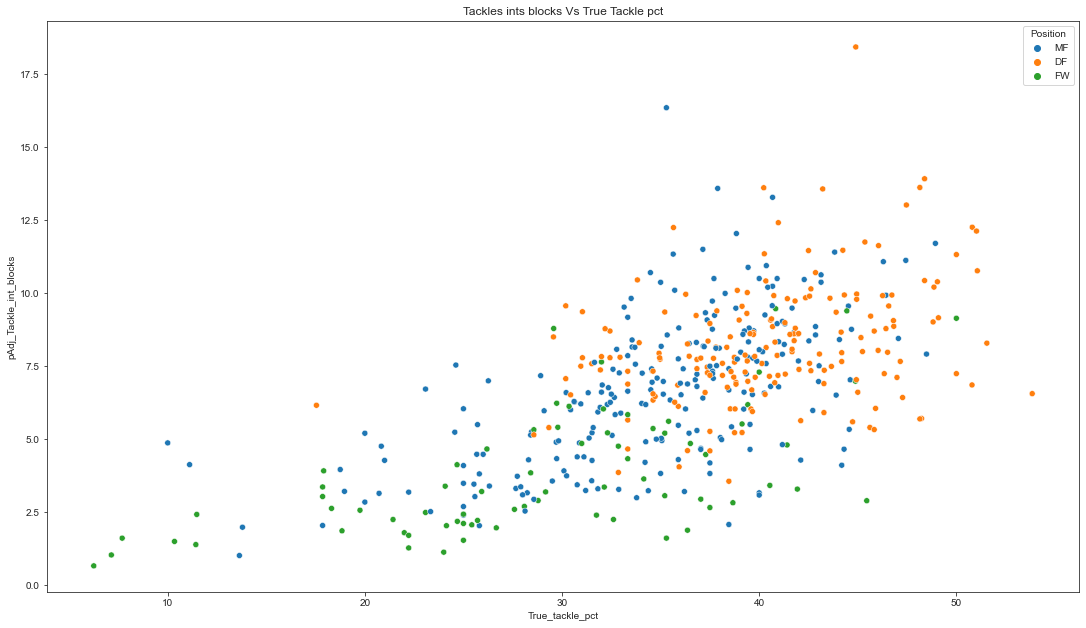

In [43]:
## deal with positional abiguity in raw data and map too three field positions 

for i in df['Position'].unique():
  if i in ['FWMF','MFFW','MFDF','DFMF']:
    df['Position'] = df['Position'].str.replace(i,'MF')

  if i in ['FWDF', 'DFFW']:
    df['Position'] = df['Position'].str.replace(i,'FW')

graph = df.loc[(df['Position']!='GK')&(df['Aerial_win_pct']<100)&
               (df['Aerial_win_pct']>0)&(df['Nineties']>5)]

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
g = sns.scatterplot(data=graph, x ='True_tackle_pct', y='pAdj_Tackle_int_blocks',hue='Position', ax=ax).set(title='Tackles ints blocks Vs True Tackle pct')


## Insight 

- a clear linear relationship between these features can be observed 
- with a majority of forwards at the bottom left  and midfielders and defenders moving up to the right scaling looks to give insight into defensive action of the league.

In [207]:
df['Squad_from_op'].unique()

array(['New England', 'D.C. United', 'Minnesota Utd', 'Real Salt Lake',
       'NYCFC', 'FC Cincinnati', 'Columbus Crew', 'CF Montréal',
       'Atlanta Utd', 'Chicago Fire', 'Seattle', 'Nashville',
       'Colorado Rapids', 'Portland Timbers', 'Inter Miami',
       'Orlando City', 'FC Dallas', 'LA Galaxy', 'Austin FC',
       'Philadelphia', 'Los Angeles FC', 'San Jose', 'Sporting KC',
       'NY Red Bulls', 'Vancouver', 'Toronto FC', 'Houston Dynamo'],
      dtype=object)

In [219]:
western = df.loc[df['Squad_from_op'].isin(['LA Galaxy', 'Austin FC',
       'Philadelphia', 'Los Angeles FC', 'San Jose', 'Sporting KC',
       'NY Red Bulls', 'Vancouver', 'Toronto FC', 'Houston Dynamo'])]

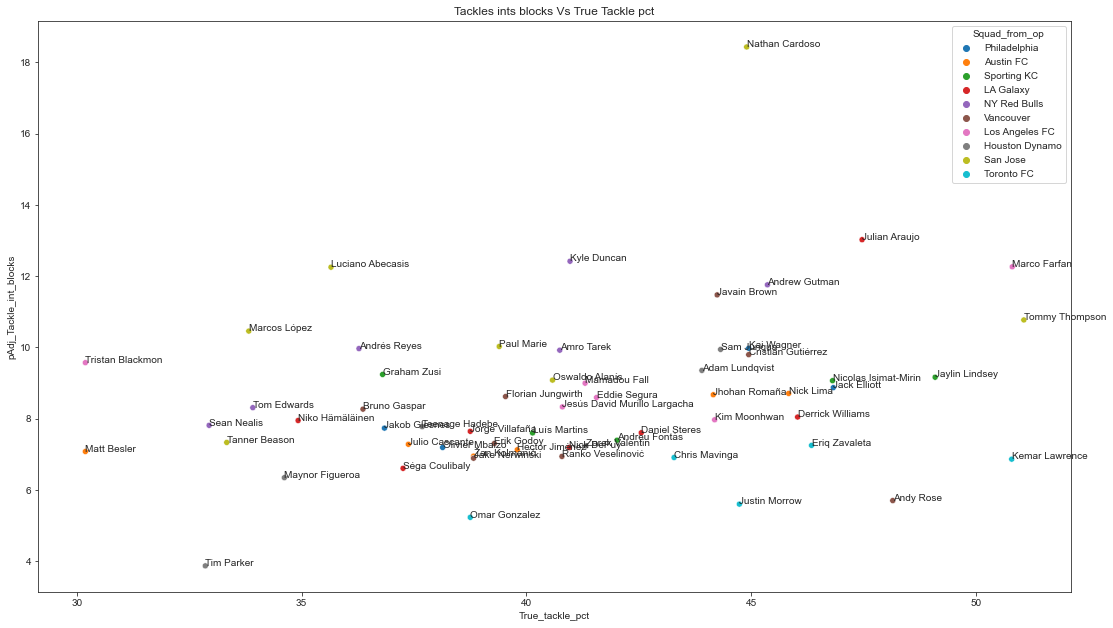

In [89]:


graph = df.loc[(df['Squad_from_op'].isin(['LA Galaxy', 'Austin FC',
       'Philadelphia', 'Los Angeles FC', 'San Jose', 'Sporting KC',
       'NY Red Bulls', 'Vancouver', 'Toronto FC', 'Houston Dynamo']))&(df['Position']=='DF')&(df['Aerial_win_pct']<100)&
               (df['Aerial_win_pct']>0)&(df['Nineties']>8)&(df['True_tackle_pct']>5)]
# (df['pAdj_Tackle_int_blocks']<35)&
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
g = sns.scatterplot(data=graph, x ='True_tackle_pct', y='pAdj_Tackle_int_blocks',hue='Squad_from_op', ax=ax).set(title='Tackles ints blocks Vs True Tackle pct')
x = graph['True_tackle_pct']
y = graph['pAdj_Tackle_int_blocks']
p = graph['player_name']
for p, x, y in zip(p, x, y):
    plt.annotate(p, (x, y))


In [90]:
df.loc[(df['True_tackle_pct']>35)&(df['Position']=='DF')&(df['Nineties']>.9)][['player_name','Nineties','True_tackle_pct','Tackle_pct_won',
                              'pAdj_Total_tackles',
                              'pAdj_Num_Dribblers_tackled','pAdj_Num_Dribbled_past','pAdj_Fouls',
                              'pAdj_Tackle_int_blocks',
                              'pAdj_def_interceptions','pAdj_Total_tackles',
                              'pAdj_Blocks', 'Squad_from_op']].sort_values(by='True_tackle_pct',ascending=False)
                                        

,player_name,Nineties,True_tackle_pct,Tackle_pct_won,pAdj_Total_tackles,pAdj_Num_Dribblers_tackled,pAdj_Num_Dribbled_past,pAdj_Fouls,pAdj_Tackle_int_blocks,pAdj_def_interceptions,pAdj_Total_tackles,pAdj_Blocks,Squad_from_op
612,Julian Dunn-Johnson,1.0,66.666667,57.1,3.211941,0.000000,0.000000,1.605970,8.029852,1.605970,3.211941,3.211941,Toronto FC
615,Vuk Latinovich,1.1,60.000000,12.5,4.796569,1.598856,0.000000,0.000000,9.593138,6.395425,4.796569,1.598856,NYCFC
621,Tom Pettersson,4.0,55.555556,30.8,2.073070,1.243842,0.000000,0.829228,7.048437,3.731525,2.073070,2.073070,FC Cincinnati
407,Steven Beitashour,6.5,53.846154,16.7,1.767322,0.252475,0.252475,0.504949,6.564340,3.029695,1.767322,2.524746,Colorado Rapids
624,Stuart Findlay,4.2,53.333333,30.2,3.149439,1.574719,0.787360,0.393680,10.235675,4.330478,3.149439,4.330478,Philadelphia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Zachary Brault-Guillard,22.8,35.869565,27.0,2.486385,1.054830,1.280865,1.883625,6.856394,3.013800,2.486385,2.637075,CF Montréal
627,Vito Wormgoor,14.3,35.714286,34.9,1.844071,0.245876,0.614690,1.844071,6.269842,2.950514,1.844071,2.335823,Columbus Crew
257,Luciano Abecasis,13.7,35.652174,33.7,5.458496,1.730743,3.195217,4.792826,12.248333,4.127156,5.458496,4.526558,San Jose
626,Sami Guediri,2.3,35.483871,31.7,7.708034,2.102191,4.204382,2.802922,10.510956,5.605843,7.708034,4.204382,Inter Miami


In [45]:
## re run this whole thing and make sure you are good with this to move to modeling with 2/23/22

In [91]:
# save df with adjusted features for further steps

df.to_csv('../data/final_per_90_and_pAdj.csv', encoding='utf-8', index=False)



In [29]:
df.head()

,fb_id,player_name,Squad_from_op,Opposing_Poss,Opposing_Touches,Nation,Position,Nineties,xA,Key_pass,...,pAdj_Yellow_cards,pAdj_Red_cards,pAdj_Second_yellow,pAdj_Fouls,pAdj_def_interceptions,pAdj_from_mish_tackles_won,pAdj_PK_conceded,pAdj_OG,pAdj_Recoveries,pAdj_Aerial_Duels_lost
0,11c30a46,Carles Gil,New England,49.1,588.941176,es ESP,MF,25.4,0.472441,5.275591,...,11.230618,0.000000,0.0,0.467942,1.537525,0.267396,0.0,0.0,10.963222,0.267396
1,acd47bc0,Julian Gressel,D.C. United,54.0,603.705882,de GER,DF,29.9,0.408027,3.210702,...,6.260108,0.000000,0.0,1.938972,3.767145,1.052585,0.0,0.0,13.905196,1.661976
2,614b26e3,Emanuel Reynoso,Minnesota Utd,49.9,614.323529,ar ARG,MF,26.5,0.332075,3.433962,...,13.821001,0.061427,0.0,3.562747,1.658520,2.641347,0.0,0.0,12.162481,1.105680
3,0adeafaa,Albert Rusnák,Real Salt Lake,49.1,567.029412,sk SVK,MF,33.8,0.213018,2.573964,...,8.191763,0.000000,0.0,1.200067,1.304421,0.834829,0.0,0.0,10.591897,0.208707
4,f99f37fc,Maximiliano Moralez,NYCFC,46.5,568.588235,ar ARG,MF,26.5,0.362264,3.132075,...,14.932715,0.066368,0.0,2.986543,1.526455,1.725558,0.0,0.0,11.083393,0.663676


## Feature vizual exploration 

- with the data now scaled to per 90 and possesion adjusted key features are to be visualised and observed below to looks for trends. 

In [33]:
# create defender only df 
defenders = df.loc[(df['Position']=='DF')&( df['Nineties'] >.9)]

In [34]:
#summary stats table transposed for df

# put higher up and show key features 
defenders.describe().T

,count,mean,std,min,25%,50%,75%,max
Opposing_Poss,216.0,49.991667,3.215475,42.600000,47.400000,50.200000,51.900000,55.100000
Opposing_Touches,216.0,594.614379,29.964880,513.205882,577.647059,593.529412,620.470588,659.294118
Nineties,216.0,16.545370,9.163085,1.000000,8.900000,17.150000,23.325000,34.000000
xA,216.0,0.052368,0.062253,0.000000,0.008474,0.030152,0.078985,0.408027
Key_pass,216.0,0.535475,0.561490,0.000000,0.125590,0.312500,0.825563,3.210702
...,...,...,...,...,...,...,...,...
pAdj_from_mish_tackles_won,216.0,1.816016,0.868210,0.000000,1.258789,1.783555,2.291729,6.174785
pAdj_PK_conceded,216.0,0.033753,0.086475,0.000000,0.000000,0.000000,0.054912,0.972621
pAdj_OG,216.0,0.020748,0.114465,0.000000,0.000000,0.000000,0.000000,1.598856
pAdj_Recoveries,216.0,12.555701,2.660552,3.714538,10.968225,12.165533,14.247242,22.106632
